In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/home/ozkan.aydemir-umw/miniconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [6]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
import numpy as np
from scipy.stats import median_abs_deviation

In [173]:
adata_dict = {}
for h5_file in os.scandir("adata_files/original/"):
    adt = sc.read(h5_file)
    sample_name = h5_file.name.split(".")[0]
    adata_dict[sample_name] = adt

In [174]:
adata = sc.concat(adata_dict)

In [175]:
rsc.get.anndata_to_GPU(adata)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["MT"] = adata.var_names.str.startswith(("MT-", "Mt-", "mt-"))
# ribosomal genes
adata.var["RIBO"] = adata.var_names.str.startswith(("RPS", "RPL", "Rps", "Rpl"))
# hemoglobin genes
adata.var["HB"] = adata.var_names.str.contains("^H[Bb][^Pp]")

rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO", "HB"], log1p=False)

Scatter plot: Total counts vs. Mitochondrial percentage

This plot shows the relationship between the total UMI counts per cell and the percentage of mitochondrial (MT) gene expression.

Cells with high mitochondrial percentages may indicate stressed or dying cells.

... storing 'obs_index' as categorical


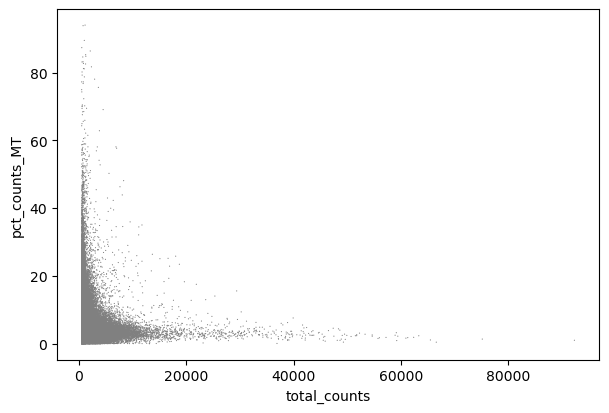

In [176]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")

Scatter plot: Total counts vs. Number of detected genes

This plot displays the correlation between the total UMI counts per cell and the number of detected genes.

A strong correlation is expected, but outliers with low gene counts might indicate empty droplets or dead cells.

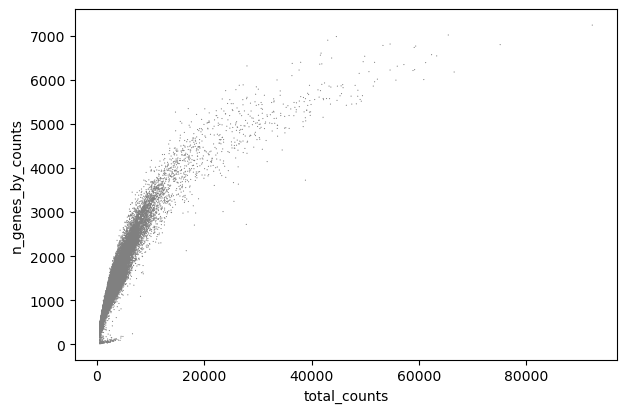

In [177]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Violin plot: Number of detected genes per cell

This violin plot visualizes the distribution of the number of detected genes per cell.

It helps identify cells with abnormally low or high gene counts, which could be filtered out.

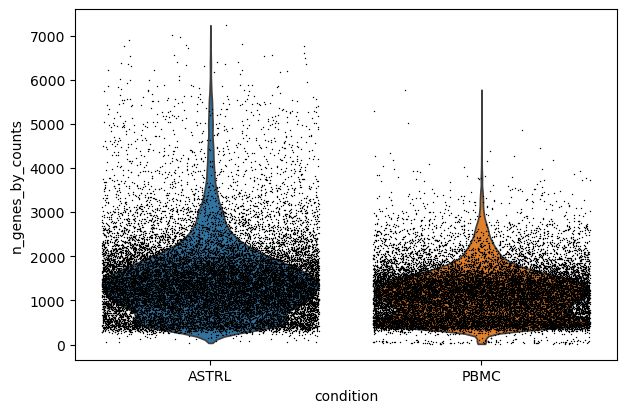

In [178]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="condition")


Violin plot: Total counts per cell

This plot shows the distribution of total counts per cell, indicating library size variation.

Extreme values may suggest low-quality or overly dominant cells.

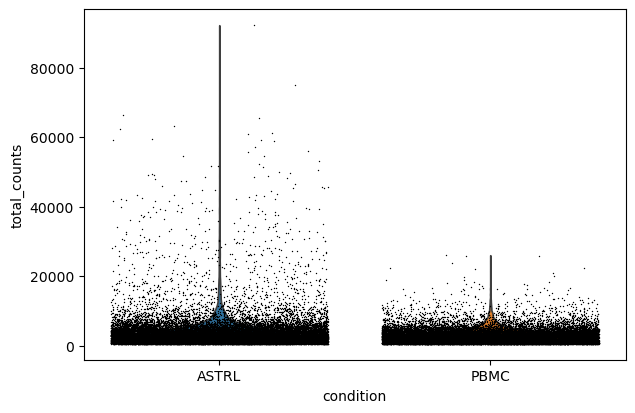

In [179]:
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="condition")


Violin plot: Percentage of mitochondrial counts per cell

This plot illustrates the distribution of mitochondrial gene expression across all cells.

High mitochondrial content could be a sign of cell stress or apoptosis.

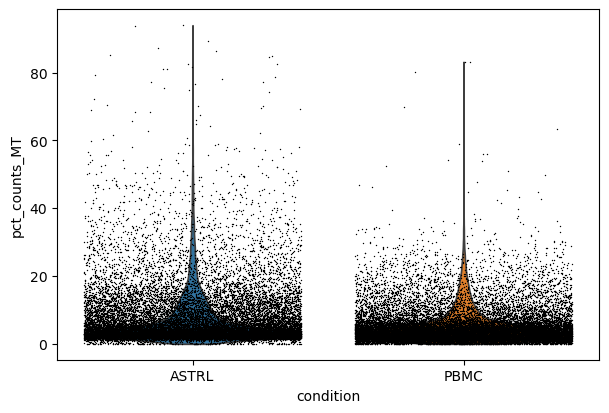

In [180]:
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="condition")

In [181]:
def is_outlier(adt, metric: str, nmads: int):
    M = adt.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [182]:
outliers = (
        is_outlier(adata, "total_counts", 3)
        | is_outlier(adata, "n_genes_by_counts", 3)
    | (adata.obs["pct_counts_MT"] > 8)
    )
outliers.sum()

np.int64(13158)

In [183]:
adata.obs["outlier"] = outliers

In [184]:
adata_ori = adata.copy()
adata = adata[(~adata.obs.outlier)].copy()

In [185]:
adata.shape, adata_ori.shape

((30601, 36601), (43759, 36601))

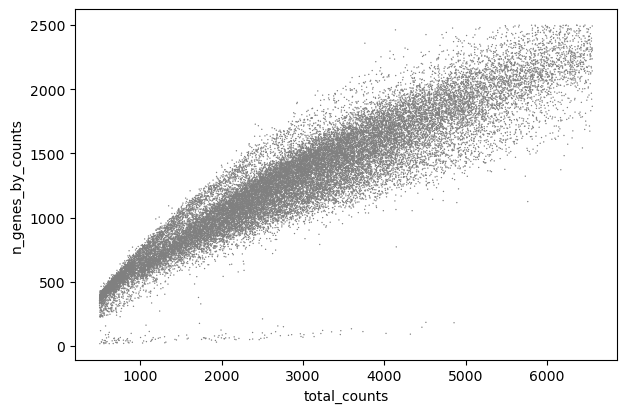

In [186]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

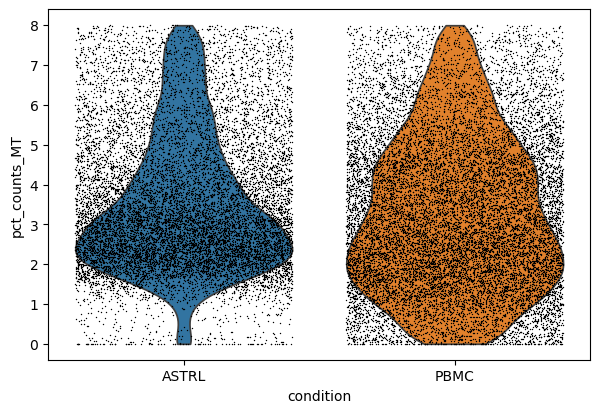

In [187]:
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="condition")

In [188]:
adata.write("adata_files/combined_filtered.h5ad")

In [126]:
rsc.pp.normalize_total(adata, target_sum=1e4)

In [127]:
rsc.pp.log1p(adata)

In [128]:
adata

AnnData object with n_obs × n_vars = 32227 × 21658
    obs: 'sample', 'patient_id', 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'log1p_total_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'log1p_total_counts_HB', 'outlier'
    var: 'MT', 'RIBO', 'HB', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells'
    uns: 'sample_colors', 'condition_colors', 'log1p'